how to store hidden personal variables in .env

In [1]:
import mysql.connector
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


In [2]:
import mysql.connector
import pandas as pd
connection = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Fantom11!!',
    database="droptime"

)

## PART I

In [3]:
# stating query to give to mysql connection
query = """
    SELECT products.product_id, sum(weight) * sum(quantity) AS TotalWeight
    FROM products 
    INNER JOIN orders_products ON products.product_id = orders_products.product_id
    INNER JOIN orders ON orders_products.order_id = orders.order_id
    INNER JOIN route_segments ON route_segments.order_id = orders.order_id
    WHERE orders.customer_id = 32 
    AND DAYOFMONTH(segment_end_time) = 13 
    AND MONTH(segment_end_time) = 2
    GROUP BY product_id
    ORDER BY totalWeight asc
"""
df = pd.read_sql_query(query, connection)


C:\Users\kawam\AppData\Local\Temp\ipykernel_8328\3727464262.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


In [4]:
df

,product_id,TotalWeight
0,46,688.0
1,60,924.0
2,82,1776.0


In [5]:
# importing to csv
df.to_csv('output.csv', index=False)


## PART II

In [6]:


query_2 = """
    SELECT *, timediff(segment_end_time, segment_start_time) AS actual_delivery_time FROM route_segments
    WHERE order_id > 0  AND segment_type = 'STOP'
"""
data = pd.read_sql_query(query_2, connection)



C:\Users\kawam\AppData\Local\Temp\ipykernel_8328\1008646449.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql_query(query_2, connection)


In [7]:
#changing format to seconds
data['actual_delivery_time'] = [td.total_seconds() for td in data['actual_delivery_time']]


In [8]:
data

,segment_id,driver_id,segment_type,order_id,segment_start_time,segment_end_time,actual_delivery_time
0,0,4,STOP,1312,2024-02-09 14:58:42,2024-02-09 15:01:56,194.0
1,2,4,STOP,1273,2024-02-24 09:26:31,2024-02-24 09:32:12,341.0
2,4,1,STOP,1036,2024-02-24 20:26:23,2024-02-24 20:26:23,0.0
3,7,2,STOP,2178,2024-02-23 09:39:03,2024-02-23 09:40:47,104.0
4,10,4,STOP,331,2024-02-26 07:03:21,2024-02-26 07:06:16,175.0
...,...,...,...,...,...,...,...
2251,4980,3,STOP,1541,2024-02-18 08:21:46,2024-02-18 08:25:55,249.0
2252,4982,3,STOP,564,2024-02-10 06:07:03,2024-02-10 06:09:20,137.0
2253,4984,4,STOP,1373,2024-02-20 16:08:08,2024-02-20 16:17:15,547.0
2254,4986,4,STOP,1879,2024-02-20 19:16:17,2024-02-20 19:20:57,280.0


In [9]:
# changing fromat to minutes and deleting any rows consisting of nonpositive values
minutes = round(data['actual_delivery_time']/60)
minutes = [x for x in minutes if x > 0]


In [10]:
# counting quantities of each minute and making note of distribution
from collections import Counter
count_dict = Counter(minutes)
ordered_counts = sorted(count_dict.items(), key=lambda x: x[0])
L = 0 
for value, count in ordered_counts:
    L += count
    print(f"{value}: {count}, {round(L/len(minutes),2)}, {round(count/len(minutes),2)}")

1.0: 484, 0.23, 0.23
2.0: 539, 0.48, 0.25
3.0: 388, 0.67, 0.18
4.0: 277, 0.8, 0.13
5.0: 190, 0.89, 0.09
6.0: 104, 0.94, 0.05
7.0: 52, 0.96, 0.02
8.0: 29, 0.97, 0.01
9.0: 17, 0.98, 0.01
10.0: 8, 0.99, 0.0
11.0: 2, 0.99, 0.0
12.0: 2, 0.99, 0.0
241.0: 7, 0.99, 0.0
242.0: 9, 1.0, 0.0
243.0: 1, 1.0, 0.0
244.0: 1, 1.0, 0.0
245.0: 2, 1.0, 0.0
246.0: 2, 1.0, 0.0
248.0: 1, 1.0, 0.0
249.0: 1, 1.0, 0.0


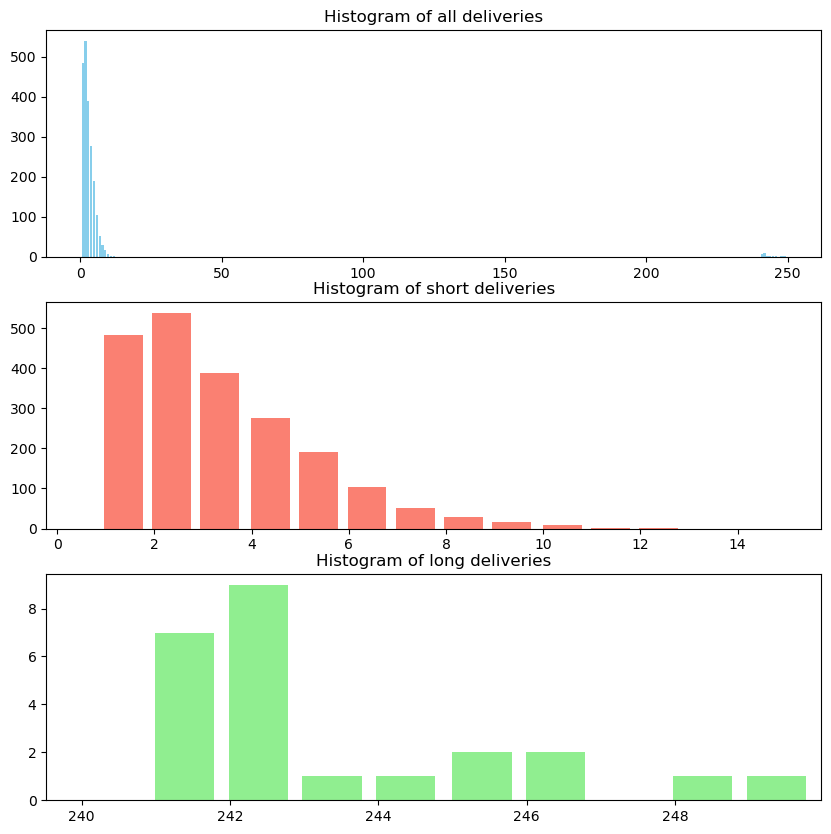

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

axs[0].hist(minutes, bins=int(max(minutes) - min(minutes)) + 1, range=(min(minutes) - 0.5, max(minutes) + 0.5), color='skyblue', width=0.8)
axs[0].set_title('Histogram of all deliveries')

axs[1].hist(minutes, bins=int(max(minutes) - min(minutes)) + 1, range=(min(minutes) - 0.5, 15), color='salmon', width=0.8)
axs[1].set_title('Histogram of short deliveries')

axs[2].hist(minutes, bins=int(max(minutes) - min(minutes)) + 1, range=(240, max(minutes) + 0.5), color='lightgreen', width=0.8)
axs[2].set_title('Histogram of long deliveries')

plt.savefig('task\plot_1.png')

plt.show()


In [12]:
query_3 = """
    SELECT *,timediff(segment_end_time, segment_start_time) AS actual_delivery_time FROM orders
    INNER JOIN route_segments ON orders.order_id = route_segments.order_id
    WHERE orders.order_id > 0  AND segment_type = 'STOP'
"""

orders_route = pd.read_sql_query(query_3, connection)

C:\Users\kawam\AppData\Local\Temp\ipykernel_8328\2991493577.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  orders_route = pd.read_sql_query(query_3, connection)


In [13]:
#changing type to seconds and omitting all rows consisting of nonpostive actual delvery times
orders_route['actual_delivery_time'] = [td.total_seconds() for td in orders_route['actual_delivery_time']]
orders_route = orders_route[orders_route['actual_delivery_time'] > 0]
orders_route

,order_id,customer_id,sector_id,planned_delivery_duration,segment_id,driver_id,segment_type,order_id,segment_start_time,segment_end_time,actual_delivery_time
0,1312,149,1,175,0,4,STOP,1312,2024-02-09 14:58:42,2024-02-09 15:01:56,194.0
1,1273,228,3,177,2,4,STOP,1273,2024-02-24 09:26:31,2024-02-24 09:32:12,341.0
3,2178,234,3,177,7,2,STOP,2178,2024-02-23 09:39:03,2024-02-23 09:40:47,104.0
4,331,272,3,178,10,4,STOP,331,2024-02-26 07:03:21,2024-02-26 07:06:16,175.0
5,2221,284,1,176,12,1,STOP,2221,2024-02-16 04:37:40,2024-02-16 04:40:06,146.0
...,...,...,...,...,...,...,...,...,...,...,...
2251,1541,305,2,175,4980,3,STOP,1541,2024-02-18 08:21:46,2024-02-18 08:25:55,249.0
2252,564,6,2,175,4982,3,STOP,564,2024-02-10 06:07:03,2024-02-10 06:09:20,137.0
2253,1373,12,1,178,4984,4,STOP,1373,2024-02-20 16:08:08,2024-02-20 16:17:15,547.0
2254,1879,43,1,178,4986,4,STOP,1879,2024-02-20 19:16:17,2024-02-20 19:20:57,280.0


In [14]:
planned_delivery = orders_route['planned_delivery_duration']
actual_delivery = orders_route['actual_delivery_time']


In [15]:
error = np.abs(planned_delivery - actual_delivery).values
orders_route['errors'] = error


In [16]:
# mean error, none outliers taken into account 
round(error[error < 2000].mean(),2)

87.11

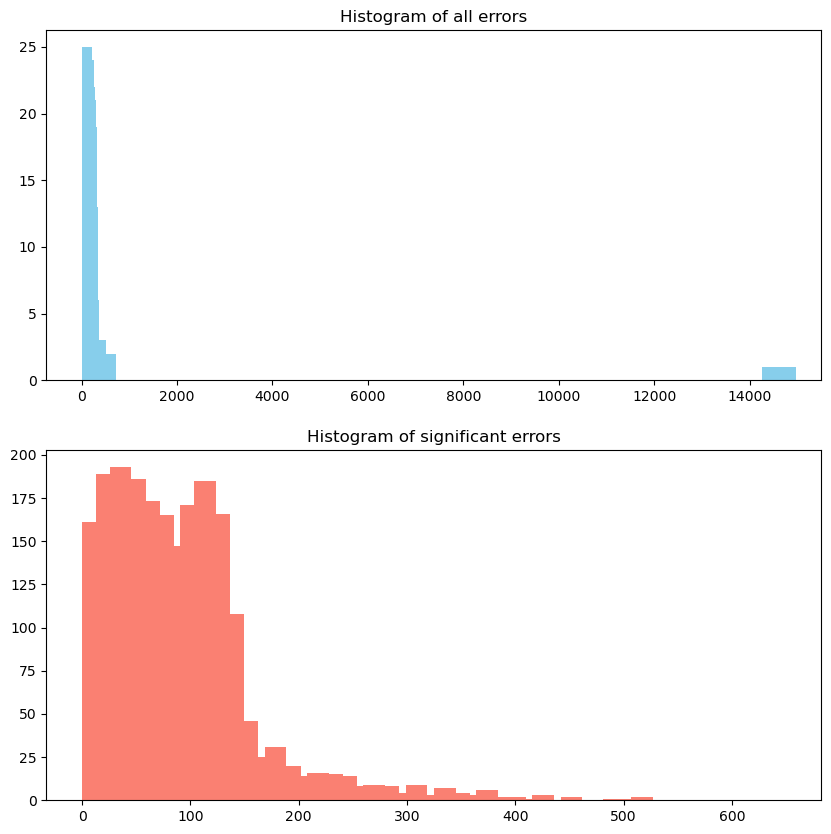

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].hist(error, bins = int(max(error)-min(error))+1, color='skyblue', width = 200)
axs[0].set_title('Histogram of all errors')

axs[1].hist(error, bins = 50, range=(min(error)-0.5, 650), color='salmon', width = 20)
axs[1].set_title('Histogram of significant errors')

plt.savefig('task\plot_2.png')

plt.show()


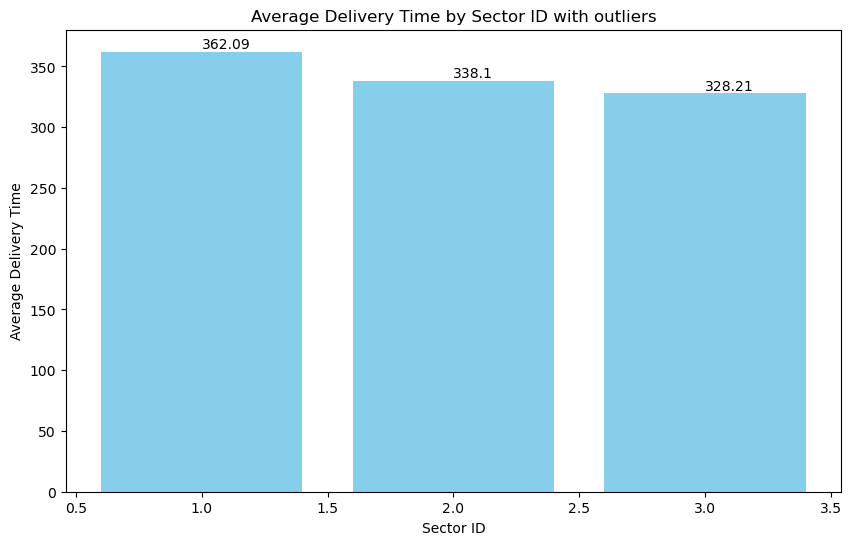

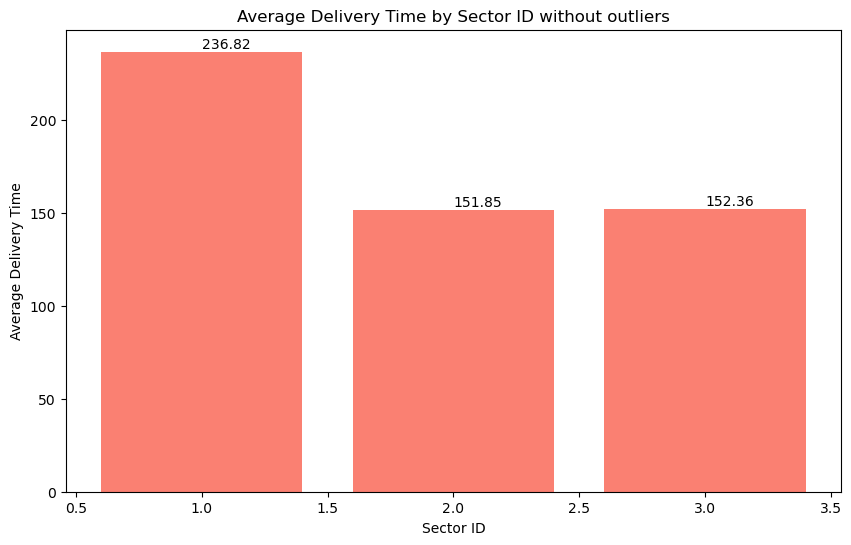

In [18]:
average_delivery_time = orders_route.groupby('sector_id')['actual_delivery_time'].mean()

plt.figure(figsize=(10, 6))
bars = plt.bar(average_delivery_time.index, average_delivery_time.values, color='skyblue')
plt.xlabel('Sector ID')
plt.ylabel('Average Delivery Time')
plt.title('Average Delivery Time by Sector ID with outliers')

# Add values to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')

plt.savefig('task/plot_3.png')
plt.show()
average_delivery_time = orders_route[orders_route['errors'] < 2000].groupby('sector_id')['actual_delivery_time'].mean()

# Plot without outliers
plt.figure(figsize=(10, 6))
bars = plt.bar(average_delivery_time.index, average_delivery_time.values, color='salmon')
plt.xlabel('Sector ID')
plt.ylabel('Average Delivery Time')
plt.title('Average Delivery Time by Sector ID without outliers')

# Add values to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')

plt.savefig('task/plot_4.png')
plt.show()

In [19]:
# taking note of distribution of sectors in outliers
new = orders_route[orders_route['errors'] > 2000]

len(new[new['sector_id'] == 1])/len(new), len(new[new['sector_id'] == 2])/len(new), len(new[new['sector_id'] == 3])/len(new)

(0.25, 0.375, 0.375)

In [20]:
# creating data consisting of delivery time, total weight ,sector_id, draiver_id,and order_id
query_4 = """
    SELECT  orders_products.order_id, 
		sector_id,
        time(route_segments.segment_end_time - route_segments.segment_start_time) AS delivery_time, 
        SUM(products.weight * orders_products.quantity) AS total_weight,
        driver_id
    FROM orders
    INNER JOIN route_segments ON orders.order_id = route_segments.order_id
    INNER JOIN orders_products ON orders.order_id = orders_products.order_id
    INNER JOIN products ON products.product_id = orders_products.product_id
    GROUP BY orders_products.order_id, delivery_time,driver_id;

"""

data_fin = pd.read_sql_query(query_4, connection)

C:\Users\kawam\AppData\Local\Temp\ipykernel_8328\2220730609.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_fin = pd.read_sql_query(query_4, connection)


In [21]:
# changing format to seconds, omitting all rows cosisting of nonpositive delivery times
data_fin['delivery_time'] = [td.total_seconds() for td in data_fin['delivery_time']]
data_fin.fillna(0, inplace=True)
data_fin = data_fin[data_fin['delivery_time'] > 0]

data_fin


,order_id,sector_id,delivery_time,total_weight,driver_id
0,0,1,309.0,7793.0,3
1,1,1,69.0,5922.0,1
4,4,2,81.0,10208.0,1
5,5,2,120.0,1092.0,3
6,6,2,43.0,928.0,1
...,...,...,...,...,...
2235,2233,3,71.0,972.0,2
2236,2234,2,207.0,13476.0,3
2238,2236,1,252.0,4863.0,3
2239,2237,2,74.0,9017.0,1


In [22]:
#removing outliers using IQR 
Q1 = data_fin['delivery_time'].quantile(0.25)

Q3 = data_fin['delivery_time'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data_fin_filtered = data_fin[(data_fin['delivery_time'] >= lower_bound) & (data_fin['delivery_time'] <= upper_bound)]

outliers = data_fin[~data_fin.index.isin(data_fin_filtered.index)]
print("Outliers:")
print(outliers)


Outliers:
      order_id  sector_id  delivery_time  total_weight  driver_id
42          42          1         2888.0        5736.0          4
79          79          2        14548.0        3710.0          3
120        120          1         2842.0        7215.0          4
127        127          1          691.0       14316.0          4
183        183          1         2708.0        5699.0          4
...        ...        ...            ...           ...        ...
2184      2182          1         2881.0       15300.0          3
2211      2209          1         2578.0        1846.0          2
2217      2215          3        16869.0       11562.0          1
2230      2228          1         2615.0        2356.0          3
2240      2238          1         2564.0        2283.0          2

[89 rows x 5 columns]


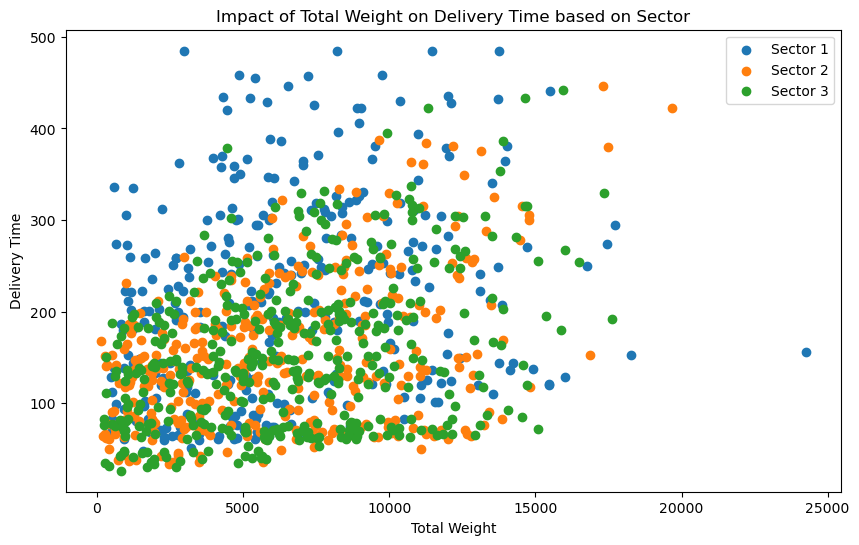

In [23]:
plt.figure(figsize=(10, 6))

for sector_id in data_fin_filtered['sector_id'].unique():
    sector_data = data_fin_filtered[data_fin_filtered['sector_id'] == sector_id]
    plt.scatter(sector_data['total_weight'], sector_data['delivery_time'], label=f'Sector {sector_id}')

plt.xlabel('Total Weight')
plt.ylabel('Delivery Time')
plt.title('Impact of Total Weight on Delivery Time based on Sector')
plt.legend()
plt.savefig('task/plot_5.png')

plt.show()

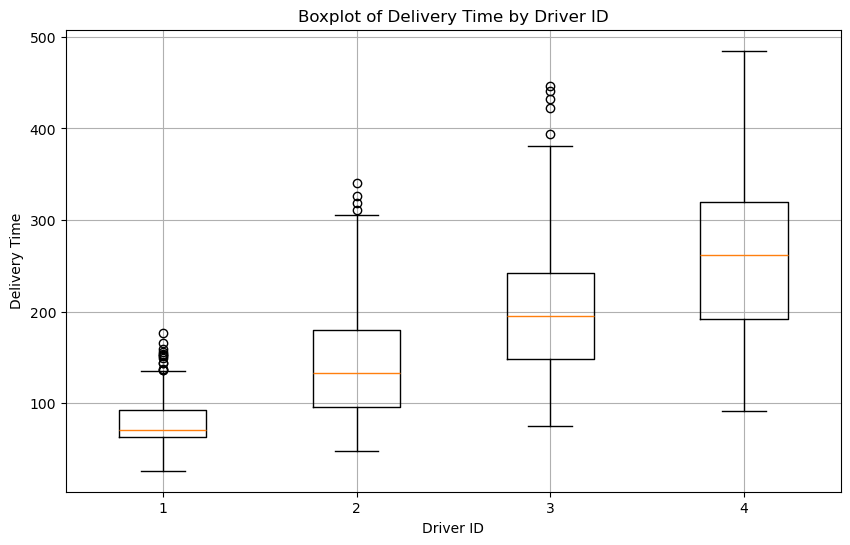

In [24]:
grouped = data_fin_filtered.groupby('driver_id')['delivery_time']

# Plotting
plt.figure(figsize=(10, 6))
plt.boxplot([grouped.get_group(sector) for sector in grouped.groups], labels=grouped.groups.keys())
plt.xlabel('Driver ID')
plt.ylabel('Delivery Time')
plt.title('Boxplot of Delivery Time by Driver ID')
plt.grid(True)
plt.savefig('task/plot_6.png')

plt.show()

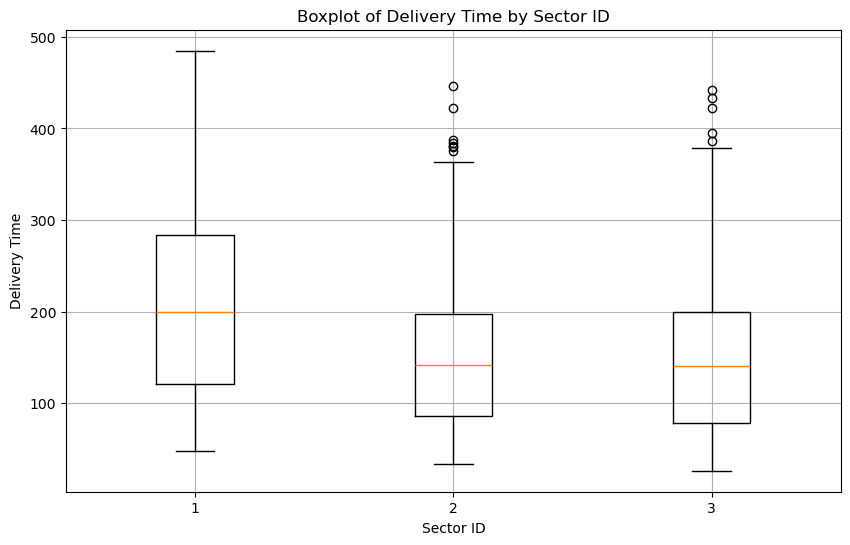

In [25]:
grouped = data_fin_filtered.groupby('sector_id')['delivery_time']

# Plotting
plt.figure(figsize=(10, 6))
plt.boxplot([grouped.get_group(sector) for sector in grouped.groups], labels=grouped.groups.keys())
plt.xlabel('Sector ID')
plt.ylabel('Delivery Time')
plt.title('Boxplot of Delivery Time by Sector ID')
plt.grid(True)
plt.savefig('task/plot_7.png')

plt.show()

## PART III

In [26]:
data_fin_filtered

,order_id,sector_id,delivery_time,total_weight,driver_id
0,0,1,309.0,7793.0,3
1,1,1,69.0,5922.0,1
4,4,2,81.0,10208.0,1
5,5,2,120.0,1092.0,3
6,6,2,43.0,928.0,1
...,...,...,...,...,...
2231,2229,3,74.0,6369.0,1
2235,2233,3,71.0,972.0,2
2236,2234,2,207.0,13476.0,3
2238,2236,1,252.0,4863.0,3


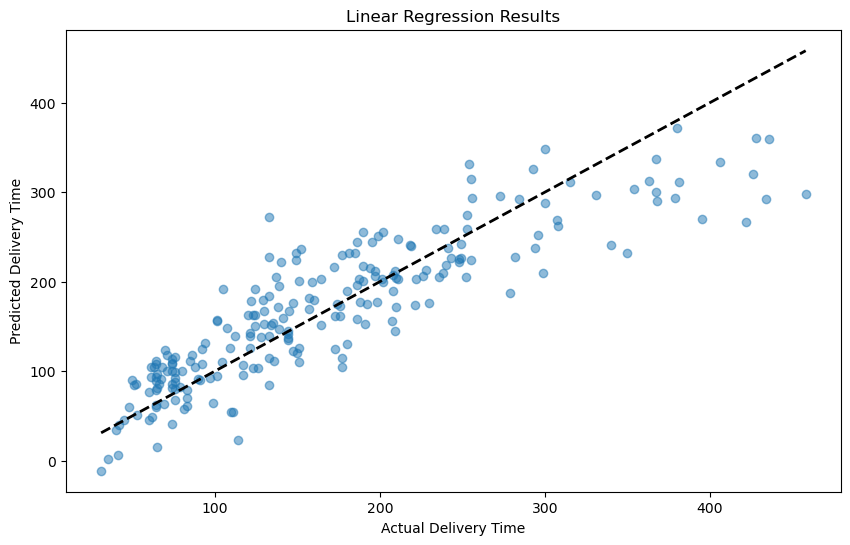

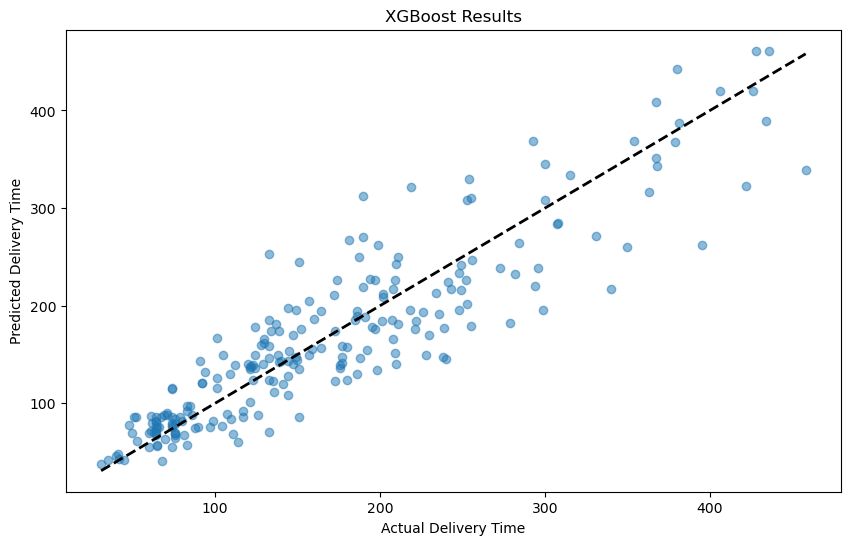

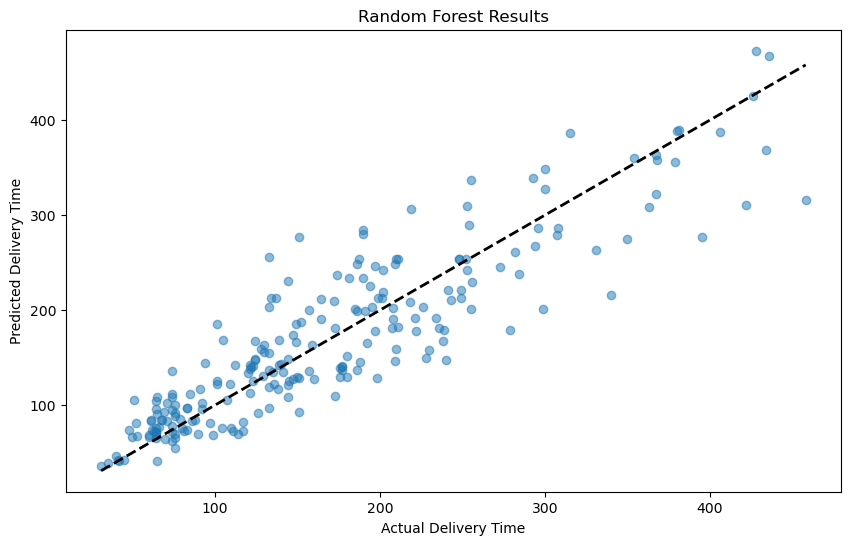

,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R-squared,Mean CV Score,Std CV Score
Linear Regression,35.00,2063.18,45.42,0.77,2171.16,185.97
XGBoost,31.15,1702.25,41.26,0.81,1974.90,308.33
Random Forest,32.29,1788.90,42.30,0.80,1873.06,249.57


In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split

X = data_fin_filtered[['total_weight','sector_id',
                       'driver_id']
]
y = data_fin_filtered['delivery_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


from sklearn.model_selection import cross_val_score

k_folds = 5  # You can adjust the number of folds as needed

error_dict_cv = {}

models = {
    'Linear Regression': LinearRegression(),
    'XGBoost': xgb.XGBRegressor(),
    'Random Forest': RandomForestRegressor()
}

for model_name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=k_folds, scoring='neg_mean_squared_error')
    
    cv_scores = -cv_scores
    
    mean_cv_score = cv_scores.mean()
    std_cv_score = cv_scores.std()
    
    error_dict_cv[model_name] = {
        'Mean CV Score': round(mean_cv_score, 2),
        'Std CV Score': round(std_cv_score, 2)
    }

cv_error_df = pd.DataFrame(error_dict_cv).T  







error_dict = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    if model_name == 'Linear Regression':
        coef = model.coef_
    y_pred = model.predict(X_test)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Plot the diagonal line
    plt.xlabel('Actual Delivery Time')
    plt.ylabel('Predicted Delivery Time')
    plt.title(f'{model_name} Results')
    plt.show()
    mae = round(mean_absolute_error(y_test, y_pred), 2)
    mse = round(mean_squared_error(y_test, y_pred), 2)
    rmse = round(mean_squared_error(y_test, y_pred, squared=False), 2)
    r2 = round(r2_score(y_test, y_pred), 2)
    
    error_dict[model_name] = {
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse,
        'R-squared': r2
    }

error_df = pd.DataFrame(error_dict).T  
error_df
error_df_with_cv = pd.concat([error_df, cv_error_df], axis=1)
error_df_with_cv


In [37]:
print(error_df_with_cv.to_markdown())

|                   |   Mean Absolute Error |   Mean Squared Error |   Root Mean Squared Error |   R-squared |   Mean CV Score |   Std CV Score |
|:------------------|----------------------:|---------------------:|--------------------------:|------------:|----------------:|---------------:|
| Linear Regression |                 35    |              2063.18 |                     45.42 |        0.77 |         2171.16 |         185.97 |
| XGBoost           |                 31.15 |              1702.25 |                     41.26 |        0.81 |         1974.9  |         308.33 |
| Random Forest     |                 32.57 |              1835.59 |                     42.84 |        0.8  |         1865.7  |         243.1  |


In [81]:
df = pd.DataFrame(coef).T

new_index = ['coef']
new_columns = ['total_weight', 'sector_id', 'driver_id']

df = df.rename(index=dict(zip(df.index, new_index)), columns=dict(zip(df.columns, new_columns)))

print(df.to_markdown())


|      |   total_weight |   sector_id |   driver_id |
|:-----|---------------:|------------:|------------:|
| coef |     0.00871171 |    -35.8297 |     66.1011 |


""


In [ ]:
connection.close()